# Data Science and Health Final Project

## SECTION I: OVERVIEW AND BACKGROUND

The rise of machine learning and data science have allowed for significant innovation within many fields--particularly in healthcare, where there is a high potential for impact through life-saving solutions and increased hospital efficiencies. The underlying concept is to utilize previous patient experiences (and the associated data) to make predictions that could both improve conditions for future patients, increase efficiency for overbooked physicians, and greatly reduce healthcare costs. The ultimate goal in this work was to develop an algorithm that utilizes the MIMIC-III database to predict the likelihood of patient readmission within 30 days of hospital discharge. The MIMIC-III database is a collection of patient data from intensive care unit hospital stays.

This sort of algorithm implemented in a hospital setting has great potential to improve outcomes for patients, assist physicians, and reduce healthcare costs. Particularly, hospital readmissions are a large source of healthcare costs and identifying patients that are of higher risk of readmission would lead to greater care prior to their initial discharge. Specifically, if a patient is readmitted within 30 days, it is likely that they were not healthy enough to leave the hospital at the time of discharge. In order to prevent this occurrence, there are financial penalties to incentivize hospitals to only discharge patients when they are stable enough to be discharged. Therefore, an algorithm that identifies patients who are at higher risk for a 30 day readmission would be hugely beneficial to the doctors caring for those patients. The doctors would then be able to exercise extreme caution when discharging these patients, ensuring they are in a stable enough condition to leave care. This extra caution would benefit doctors, hospitals, and most importantly the health of patients.

## SECTION II: DATA

### 1. Admissions and Patient Info

#### a. Import Data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sqlite3 # library for working with sqlite database
conn = sqlite3.connect("./data/data.db") # Create a connection to the on-disk database

The tables that were included in our data.db file are shown below. Lab events tables were dealt with separately.

In [2]:
pd.read_sql("SELECT * FROM sqlite_master where type='table'", conn)

,type,name,tbl_name,rootpage,sql
0,table,patients,patients,2,"CREATE TABLE patients(ROW_ID INT,SUBJECT_ID IN..."
1,table,admissions,admissions,639,"CREATE TABLE admissions(ROW_ID INT,SUBJECT_ID ..."
2,table,icustays,icustays,3515,"CREATE TABLE icustays(ROW_ID INT,SUBJECT_ID IN..."
3,table,diagnoses_icd,diagnoses_icd,4944,"CREATE TABLE diagnoses_icd(ROW_ID INT,SUBJECT_..."
4,table,drgcodes,drgcodes,9061,"CREATE TABLE drgcodes(ROW_ID INT,SUBJECT_ID IN..."


The features incorporated in the admissions table are as follows. HADM_ID, ADMITTTIME, DISCHTIME, and HOSPITAL_EXPIRE_FLAG are the relevant columns.

In [3]:
all_admissions = pd.read_sql("""SELECT * FROM admissions""", conn)
print(all_admissions.shape)
all_admissions.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,,CATHOLIC,MARRIED,WHITE,,,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,,,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,,PROTESTANT QUAKER,SINGLE,WHITE,,,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


The relevant columns from the admissions table, sorted by SUBJECT_ID, are then extracted:

In [4]:
all_admissions = all_admissions.sort_values('SUBJECT_ID')
all_admissions_info = all_admissions[['SUBJECT_ID', 'HADM_ID', 'HOSPITAL_EXPIRE_FLAG']]
all_admissions[5:10]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
216,6,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,,CATHOLIC,,WHITE,,,NEWBORN,0,1
217,7,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,,CATHOLIC,,WHITE,,,NEWBORN,0,1
218,8,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,,UNOBTAINABLE,,UNKNOWN/NOT SPECIFIED,2149-11-09 11:13:00,2149-11-09 13:18:00,HEMORRHAGIC CVA,1,1
219,9,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Medicaid,,UNOBTAINABLE,,BLACK/AFRICAN AMERICAN,,,NEWBORN,0,1
220,10,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,,OTHER,MARRIED,WHITE,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,0,1


#### b. Patient Selection

Two dataframes with subsets of relevant patients ('one_admission', 'mult_admissions') are extracted from the database in order to create a 'relevant_patients' dataframe.

Relevant patients are those who survived their first admission and/or have been admitted multiple times. The final 'relevant_patients' dataframe consists only of the SUBJECT_ID column for relevant patients, and is created by concatenating 'one_admission_survivors' and 'mult_admissions'; namely, people who survived their only admission and people who had multiple admissions (and therefore survived their first admission).

In [5]:
# 'First' admission if it is a patient's first ever admission
# Exclude patients who die during their 'first' visit

one_admission = pd.read_sql("""SELECT SUBJECT_ID, HOSPITAL_EXPIRE_FLAG FROM admissions
GROUP BY SUBJECT_ID
HAVING COUNT(SUBJECT_ID) = 1
""", conn)
print("Number of people admitted once: " + str(one_admission.shape[0]))
one_admission_deaths = one_admission.iloc[one_admission['HOSPITAL_EXPIRE_FLAG'].values == 1]
one_admission_deaths = one_admission_deaths[['SUBJECT_ID']]
print("People who died on their first admission:")
print(one_admission_deaths.shape[0])
print(one_admission_deaths.head())

one_admission_survivors = one_admission[one_admission['HOSPITAL_EXPIRE_FLAG'] == 0]
one_admission_survivors = one_admission_survivors[['SUBJECT_ID']]
print("People who only had one admission but survived it: " + str(one_admission_survivors.shape[0]))
print(one_admission_survivors[0:15])

mult_admissions = pd.read_sql("""SELECT SUBJECT_ID FROM admissions
GROUP BY SUBJECT_ID
HAVING COUNT(SUBJECT_ID) > 1
ORDER BY CAST(SUBJECT_ID AS UNSIGNED) ASC
""", conn)
print("People who had multiple admissions: " + str(mult_admissions.shape[0]))
print(mult_admissions.head())

# Concatenate all subject IDs from patients who survived their first visit
relevant_patients = pd.concat([one_admission_survivors, mult_admissions], axis = 0)
relevant_patients.columns = relevant_patients.columns.str.strip()
relevant_patients = relevant_patients.sort_values('SUBJECT_ID')
print("Patients who survived their first visit: " + str(relevant_patients.shape[0]))
relevant_patients[0:4]

Number of people admitted once: 38983
People who died on their first admission:
4351
    SUBJECT_ID
7            9
10          12
23          31
43          56
71          91
People who only had one admission but survived it: 34632
    SUBJECT_ID
0            2
1            3
2            4
3            5
4            6
5            7
6            8
8           10
9           11
11          13
12          16
13          18
14          19
15          20
16          22
People who had multiple admissions: 7537
   SUBJECT_ID
0          17
1          21
2          23
3          34
4          36
Patients who survived their first visit: 42169


,SUBJECT_ID
0,2
1,3
2,4
3,5


A dataframe containing all HADM_ID values and attached HOSPITAL_EXPIRE_FLAG values for relevant patients was also generated. This will be used later when generating truth labels.

In [6]:
# All admissions information for relevant patients
all_admissions_for_relevant_patients = pd.merge(relevant_patients, all_admissions_info, how='inner', on='SUBJECT_ID')
print(all_admissions_for_relevant_patients.shape[0])
all_admissions_for_relevant_patients[4:9]

54625


,SUBJECT_ID,HADM_ID,HOSPITAL_EXPIRE_FLAG
4,6,107064,0
5,7,118037,0
6,8,159514,0
7,10,184167,0
8,11,194540,0


#### c. Features

##### i. Hospital Length of Stay

In [7]:
# Features for all patients
# Only take table info for subjects that are included in our design matrix
# Filter via inner join
admissions_info = pd.read_sql("""SELECT adm.SUBJECT_ID, HADM_ID, ADMITTIME, DISCHTIME
                                 FROM admissions adm
                                 INNER JOIN patients pat
                                 ON adm.SUBJECT_ID = pat.SUBJECT_ID
                                 ORDER BY pat.SUBJECT_ID ASC
                                 """, conn)
admissions_info['DISCHTIME'] = pd.to_datetime(admissions_info['DISCHTIME'])
admissions_info['ADMITTIME'] = pd.to_datetime(admissions_info['ADMITTIME'])

In [8]:
# Further process information for admissions and ICU stays
# Calculate length of stay for each admission
admissions_feats= pd.read_sql("""SELECT adm.SUBJECT_ID, HADM_ID, ADMITTIME, DISCHTIME
                                 FROM admissions adm
                                 INNER JOIN patients pat
                                 ON adm.SUBJECT_ID = pat.SUBJECT_ID
                                 ORDER BY pat.SUBJECT_ID ASC
                                 """, conn)

# 'HOS_LOS' is length of stay in HOSPITAL, in seconds ('TimedeltaProperties' object only
# has days, seconds, microseconds as attributes)
admissions_feats['HOS_LOS'] = (admissions_info['DISCHTIME'] - admissions_info['ADMITTIME']).dt.days
admissions_feats['HOS_LOS'] = (admissions_feats['HOS_LOS'] - admissions_feats['HOS_LOS'].mean())/admissions_feats['HOS_LOS'].std()

# Only get information from FIRST admission
admissions_feats.sort_values('DISCHTIME')
admissions_feats = admissions_feats.drop_duplicates(subset='SUBJECT_ID', keep='first')
admissions_feats = admissions_feats[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'HOS_LOS']]

##### ii. Age

Another potentially useful feature is age because older patients may be more likely to require readmission. We determined the age of each patient by subtracting the the date of birth from the time of the first hospital admission. Note that the creators of the MIMIC database set the age of all patients older than 89 years to 300 years to comply with HIPAA requirements. For this project, we reset the age of the 300 year old patients to 89 years old. Here, we calculate the age of each patient in days. We normalize the age by subtracting the mean and dividing by the standard deviation.

In [9]:
# Join the patients table with the admissions table
pat_adm_df = pd.read_sql("""SELECT pat.SUBJECT_ID, pat.DOB, adm.ADMITTIME
                            FROM patients pat
                            INNER JOIN admissions adm
                            ON pat.SUBJECT_ID = adm.SUBJECT_ID
                            ORDER BY pat.SUBJECT_ID ASC""", conn)

# Patient's age at first admission time
admissions_feats['age'] = (pd.to_datetime(pat_adm_df['ADMITTIME']) - pd.to_datetime(pat_adm_df['DOB'])).dt.days

# Fix overflow issues with 300 year old patients, change age to 89 years
admissions_feats["age"].loc[admissions_feats["age"] < 0] = 32485 # age in days

# Normalize the age to achieve zero mean and unit variance
admissions_feats["age"] = (admissions_feats["age"] - admissions_feats["age"].mean())/admissions_feats["age"].std()

/Users/kevinmchu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### d. Generate Truth Labels

Next, we generate the ground truth labels to indicate whether a patient was readmitted within 30 days. For this project, we were only interested in using information from the patient's first admission to determine whether their second admission would occur within 30 days.

In [10]:
# !!! Need to generate truth labels for ONLY:
# - patients who survived their first admission
# - the last ICU stay, if there were multiple
# - the first admission, if there were multiple

# Generate additional columns:
# Append truth labels column (Was patient readmitted within 30 days?)
subj_adm = all_admissions_for_relevant_patients["SUBJECT_ID"].value_counts()
subj_adm = subj_adm.sort_index()

mult_adm_subj = subj_adm.index[subj_adm > 1]

# Instantiate to all zeros
truth = np.zeros((len(subj_adm)))

subj_adm_idx = list(subj_adm.index)

for subject in mult_adm_subj:
    temp_df = admissions_info[admissions_info["SUBJECT_ID"] == subject]
    
    # Get time between first discharge and second admission
    first_disc_time = temp_df["DISCHTIME"].iloc[0]
    second_adm_time = temp_df["ADMITTIME"].iloc[1]
    days_to_readm = (pd.to_datetime(second_adm_time) - pd.to_datetime(first_disc_time)).days
    
    # If readmitted within 30 days, set truth to 1
    if days_to_readm <= 30:
        truth[subj_adm_idx.index(subject)] = 1
        
truth_df = pd.DataFrame({'SUBJECT_ID': subj_adm_idx, 'READM': np.array(truth, dtype='int')})
print(truth_df.head())
print(truth_df.shape)

   SUBJECT_ID  READM
0           2      0
1           3      0
2           4      0
3           5      0
4           6      0
(42169, 2)


In [11]:
subj_hadm_df = pd.merge(relevant_patients["SUBJECT_ID"].to_frame(),
                        admissions_feats[["SUBJECT_ID", "HADM_ID"]],
                        how='inner', on='SUBJECT_ID')

In [12]:
# Create TRUTH.csv file
truth_and_hadm_df = pd.merge(truth_df, subj_hadm_df)
truth_and_hadm_array = truth_and_hadm_df.get_values()

# Save
#np.savetxt("TRUTH.csv", truth_and_hadm_array, fmt='%d', delimiter=',')

#### e. Subset the Data

The data are highly imbalanced, where only 5 percent of patients are readmitted within 30 days of their first admission. Classifiers trained on highly imbalanced datasets may become biased to the majority class and may not generalize well to examples from the minority class. To mitigate this issue, we randomly downsample the majority class so that both classes have the same number of observations. 

In [13]:
import random

# Extract class 0 and class 1 admissions
class0 = truth_and_hadm_df.loc[truth_and_hadm_df["READM"]==0] # not readmitted within 30 days
class1 = truth_and_hadm_df.loc[truth_and_hadm_df["READM"]==1] # readmitted within 30 days

# Downsample majority class to same # of observations as minority class
# Generate random indices for downsampling
rand_idx = random.sample(range(0, len(class0)), len(class1))
class0_subset = class0.iloc[rand_idx]

# Concatenate hadm_ids and save to file
balanced_hadm_ids = np.concatenate((class0_subset["HADM_ID"], class1["HADM_ID"]))
#np.savetxt('csv/hadm_ids_balanced.csv', balanced_hadm_ids, fmt='%d', delimiter=',')

### 2. Lab Events

In this section, we look at information in the lab events table. This table contains information about various laboratory measurements done on a patient. 

#### a. Import Data

In [14]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sqlite3

In [15]:
# Database connection

# This database contains a table with a subset of patients.
# The majority class is downsampled so that the classes are balanced.
conn2 = sqlite3.connect("./data/labevents_balanced.db") 

# This database contains a table that links ITEMID to LABEL
conn3 = sqlite3.connect("./data/lab_events.db")

In [16]:
# Dataframe creation

# Contains lab measurements for patient subset
lab_events_df = pd.read_sql("""SELECT * FROM labevents""", conn2)

# Links ITEMID to LABEL
lab_items_df = pd.read_sql("""SELECT * FROM lab_items""", conn3)

# Convert to numeric data types
lab_events_df["SUBJECT_ID"] = pd.to_numeric(lab_events_df["SUBJECT_ID"])
lab_events_df["HADM_ID"] = pd.to_numeric(lab_events_df["HADM_ID"]).astype(int)
lab_events_df["VALUENUM"] = pd.to_numeric(lab_events_df["VALUENUM"])

# Merge with labels for laboratory measurements
lab_events_df = lab_events_df.merge(lab_items_df[['ITEMID','LABEL']], left_on='ITEMID', right_on='ITEMID')

lab_events_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,LABEL
0,12019,30,104557,50800,2172-10-14 16:06:00,ART,NaN,,,SPECIMEN TYPE
1,34727,71,111944,50800,2164-02-03 21:07:00,ART,NaN,,,SPECIMEN TYPE
2,34766,71,111944,50800,2164-02-03 23:14:00,ART,NaN,,,SPECIMEN TYPE
3,34772,71,111944,50800,2164-02-04 02:30:00,ART,NaN,,,SPECIMEN TYPE
4,32967,68,170467,50800,2173-12-15 12:39:00,ART,NaN,,,SPECIMEN TYPE


#### b. Truth Labels

In [17]:
# Here, we extract the truth labels. A label of 1 indicates that a patient was
# readmitted within 30 days, and a label of 0 indicates otherwise.

# Load in information about truth labels and corresponding admissions
# Column 1: SUBJECT_ID
# Column 2: TRUTH
# Column 3: HADM_ID
truth_array = np.loadtxt("csv/TRUTH.csv", delimiter=',', skiprows=1)

# Create a dataframe with truth labels
truth_df = pd.DataFrame(truth_array, columns=['SUBJECT_ID', 'TRUTH', 'HADM_ID'])

# Convert to ints
truth_df["SUBJECT_ID"] = truth_df["SUBJECT_ID"].astype(int)
truth_df["TRUTH"] = truth_df["TRUTH"].astype(int)
truth_df["HADM_ID"] = truth_df["HADM_ID"].astype(int)

#### c. Relevant Admissions

In [18]:
# Only interested in lab events corresponding to the relevant admissions, i.e. those where
# patient did not die during the first visit
relevant_lab_events_df = lab_events_df.merge(truth_df, on='HADM_ID')

# Get relevant truth labels
hadm_df = pd.DataFrame(lab_events_df["HADM_ID"].unique(), columns={'HADM_ID'})

# Get updated truth_df
relevant_truth_df = hadm_df.merge(truth_df, how='inner', on='HADM_ID')

#### d. Lab Features

Here, we extract features from the laboratory measurements. Lab measurements were made in different fluids including blood, cerebrospinal fluid, and urine. Some of the tests include red blood cell count, white blood cell count, and the glucose concentration. For all lab tests, we calculate the proportion of measurements that were flagged as abnormal. The rationale behind this approach is that a higher proportion of abnormal measurements may indicate that the patient is sicker, making it more likely that they will be readmitted within 30 days.

In [19]:
# Create binary variable to represent whether measurement is abnormal
relevant_lab_events_df['ABNORMAL'] = 0
relevant_lab_events_df.loc[relevant_lab_events_df['FLAG']=='abnormal', 'ABNORMAL'] = 1

# Get proportion of measurements that are abnormal
abnormal_df = relevant_lab_events_df.groupby(['HADM_ID', 'ITEMID'], as_index = False)['ABNORMAL'].mean()

# Get list of measurement names
meas_type = np.unique(lab_events_df["ITEMID"].get_values())

# Initially set design matrix equal to truth dataframe
design_mat_df = relevant_truth_df

# For all measurement types, get the proportion of abnormal values
for meas in meas_type:
    # Get proportion of abnormal values
    curr_df = abnormal_df.loc[abnormal_df["ITEMID"] == meas, ["HADM_ID", "ABNORMAL"]]
    
    # Rename
    rename_as = meas + "_ABNORMAL"
    curr_df = curr_df.rename(index=str, columns={"ABNORMAL": rename_as})
    
    # Merge
    design_mat_df = design_mat_df.merge(curr_df, how='left', on='HADM_ID')

#### e. Add Admissions Features

In [20]:
# Merge hospital length of stay and age onto existing design matrix
design_mat_df = design_mat_df.merge(admissions_feats[["HADM_ID", "HOS_LOS", "age"]], how='left', on='HADM_ID')

# Create dataframe with feature names
adm_feat_names_df = pd.DataFrame(["1st Admission Length of Stay", "Age"], columns={"Feature"})

# Remove hospital admission and subject ID columns
design_mat_df = design_mat_df.drop(columns=["HADM_ID", "SUBJECT_ID"])

### 3. Feature Selection

In this section, we describe a technique to reduce the number of features in the data. The reason for selecting only a subset of features is to avoid the curse of dimensionality, which asserts that the hypervolume increases much faster than observations can fill the space. If the number of features is large compared to the number of observations, a classifier trained on the data will tend to overfit the training set. An additional challenge associated with this dataset is that different types of lab tests are performed on different patients, resulting in a substantial number of missing values. This exacerbates the data sparsity problem associated with high dimensional data. To mitigate this concern, we select features that have at least 50 percent non-missing values in the training set because features with many missing values are not informative for classification. 

In [21]:
from sklearn.model_selection import train_test_split

# Make train and test splits
train_df, test_df = train_test_split(design_mat_df, test_size = 0.33, random_state = 0)

# Select features that have at least 50% non-missing values in the training set
prop_non_missing = (~train_df.isna()).sum()/len(train_df)
threshold = 0.5

# Select same features in training and testing set
train_df = train_df.loc[:, prop_non_missing > threshold]
test_df = test_df.loc[:, prop_non_missing > threshold]

After feature selection, we obtained a set of 56 features describing the proportion of abnormal measurements. The table below lists the lab test and the fluid from which samples were obtained.

In [22]:
# Get names of selected features
all_columns = train_df.iloc[:, 1:-2].columns
lab_meas_df = pd.DataFrame(all_columns, columns={"ITEMID"})

# Strip _ABNORMAL from the name
lab_meas_df["ITEMID"] = lab_meas_df["ITEMID"].replace(to_replace="_ABNORMAL", value="", regex=True)

# Get labels and fluid from lab_items_df
lab_meas_df = lab_meas_df.merge(lab_items_df.loc[:,["LABEL", "FLUID", "ITEMID"]], how='inner', on='ITEMID')
lab_feat_names_df = pd.DataFrame(lab_meas_df["LABEL"] + " " + lab_meas_df["FLUID"] + '-Abnormal', columns={"Feature"})

### 4. Missing Values

After performing feature selection, many of the proportions are missing values because not all lab tests are performed on a patient. Classifiers often cannot handle missing values, so a technique must be used to address the missing values. We address the problem by adding a set of indicator variables to denote missing values and by imputing the data.

#### a. Indicator Variables
For the lab measurements, we add indicator variables because whether a patient has a certain lab measurement done may give clues about their health. The indicator variable is set to 0 if the corresponding feature is non-missing and 1 if the feature is missing. This results in an additional set of 56 features.

In [23]:
# Here, we include additional features to indicate the presence of any remaining missing values
missing_train_df = train_df.isna().astype(int)
missing_test_df = test_df.isna().astype(int)

# Only need indicator variables if there are missing values in a column
missing_train_df = missing_train_df.loc[:, missing_train_df.sum() != 0]
missing_test_df = missing_test_df.loc[:, missing_test_df.sum() != 0]

# Merge
train_df = pd.merge(train_df, missing_train_df, left_index=True, right_index=True)
test_df = pd.merge(test_df, missing_test_df, left_index=True, right_index=True)

# Get feature names
missing_feat_names_df = lab_feat_names_df + "-Missing?"

#### b. Imputation

Here, we impute the missing values by replacing them with zeros.

In [24]:
# Replace NaN values
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [25]:
# Extract X and y values from training and testing dataframes
X_train = train_df.iloc[:, 1:len(train_df.columns)].get_values()
y_train = train_df.iloc[:, 0]
X_test = test_df.iloc[:, 1:len(test_df.columns)].get_values()
y_test = test_df.iloc[:, 0]

### 5. Final Features

The final features used to train the model are the patient age, length of stay for the first admission, proportion of abnormal lab measurements, and presence of missing measurements. The table below shows a full list of the final features used to train and test the classification models.

In [26]:
# Get array of all feature names
all_feat_names = np.concatenate((adm_feat_names_df.get_values(),
                                 lab_feat_names_df.get_values(),
                                 missing_feat_names_df.get_values()))

# Format into a DataFrame
all_feat_names_df = pd.DataFrame(all_feat_names, columns={"Feature"})
pd.set_option('display.max_rows', 114)
all_feat_names_df

,Feature
0,1st Admission Length of Stay
1,Age
2,Base Excess Blood-Abnormal
3,Calculated Total CO2 Blood-Abnormal
4,Lactate Blood-Abnormal
5,pCO2 Blood-Abnormal
6,pH Blood-Abnormal
7,pO2 Blood-Abnormal
8,"Potassium, Whole Blood Blood-Abnormal"
9,Alanine Aminotransferase (ALT) Blood-Abnormal


## SECTION III: EXPLORATORY DATA VISUALIZATION AND ANALYSIS

In [27]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sqlite3
import seaborn as sns
import pylab
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### 1. Visualize Patient and Hospital Admission Data
##### Age,  Length of Hospital Stay, 30 Day Readmission 

This figure shows the age and length of hospital stay for the patients in the dataset. Each color represents a different class where blue means 'not readmitted in 30 days' and orange means 'readmitted in 30 days'.

In [28]:
# Collect data

conn = sqlite3.connect("./data/data.db") 

#Age
pat_vis_data = pd.read_sql("""SELECT pat.SUBJECT_ID, pat.DOB, adm.ADMITTIME
                            FROM patients pat
                            INNER JOIN admissions adm
                            ON pat.SUBJECT_ID = adm.SUBJECT_ID
                            ORDER BY pat.SUBJECT_ID ASC""", conn)
pat_adm_df = pd.read_sql("""SELECT pat.SUBJECT_ID, pat.DOB, adm.ADMITTIME
                            FROM patients pat
                            INNER JOIN admissions adm
                            ON pat.SUBJECT_ID = adm.SUBJECT_ID
                            ORDER BY pat.SUBJECT_ID ASC""", conn)
pat_vis_data['Age'] = (pd.to_datetime(pat_adm_df['ADMITTIME']) - pd.to_datetime(pat_adm_df['DOB'])).dt.days

#LOS
admissions_info = pd.read_sql("""SELECT adm.SUBJECT_ID, HADM_ID, ADMITTIME, DISCHTIME
                                 FROM admissions adm
                                 INNER JOIN patients pat
                                 ON adm.SUBJECT_ID = pat.SUBJECT_ID
                                 ORDER BY pat.SUBJECT_ID ASC
                                 """, conn)
admissions_info['DISCHTIME'] = pd.to_datetime(admissions_info['DISCHTIME'])
admissions_info['ADMITTIME'] = pd.to_datetime(admissions_info['ADMITTIME'])
pat_vis_data['Hos_LOS'] = (pd.to_datetime(admissions_info['DISCHTIME']) - pd.to_datetime(admissions_info['ADMITTIME'])).dt.days

# Gender
pat_vis_data['Gender'] = pd.read_sql("""SELECT GENDER FROM patients""", conn)

# 30 Day Readmission
truth_array = np.loadtxt("TRUTH.csv", delimiter=',', skiprows=1)
truth_df = pd.DataFrame(truth_array, columns=['SUBJECT_ID', 'TRUTH', 'HADM_ID'])
truth_df["SUBJECT_ID"] = truth_df["SUBJECT_ID"].astype(int)
truth_df["TRUTH"] = truth_df["TRUTH"].astype(int)
truth_df["HADM_ID"] = truth_df["HADM_ID"].astype(int)
pat_vis_data = pat_vis_data.merge(truth_df, on='SUBJECT_ID', how='inner')

# Clean up final dataframe
pat_vis_data = pat_vis_data.drop_duplicates(subset='SUBJECT_ID').drop(['DOB','ADMITTIME','HADM_ID','SUBJECT_ID'], axis=1)
pat_vis_data['TRUTH'].loc[pat_vis_data['TRUTH'] == 0] = 'Not Readmitted Within 30 Days'
pat_vis_data['TRUTH'].loc[pat_vis_data['TRUTH'] == 1] = 'Readmitted Within 30 Days'
pat_vis_data['Age'] = pat_vis_data['Age']/365
pat_vis_data['Age'].loc[pat_vis_data['Age'] < 0] = 89
pat_vis_data['Age'] = pat_vis_data['Age'].astype(float)
pat_vis_data['Hos_LOS'] = pat_vis_data['Hos_LOS'].astype(float)

/Users/kevinmchu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


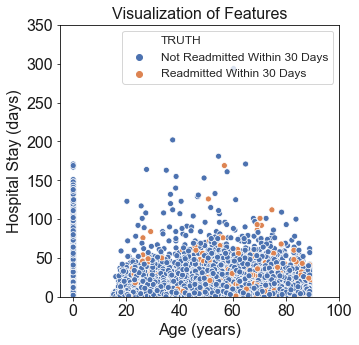

In [29]:
# Visualize all data for relevant patients

import pylab
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
sns.set()
sns.set_style("white")
cmap = sns.color_palette(n_colors=2)

sns.scatterplot(x="Age", y="Hos_LOS",
                     hue="TRUTH",
                     palette=cmap, sizes=(10, 30),
                     data=pat_vis_data)

plt.axis((-5, 100, 0, 350))
plt.title('Visualization of Features', fontsize=16)
plt.xlabel('Age (years)', fontsize=16)
plt.ylabel('Hospital Stay (days)', fontsize=16)
plt.legend(loc="upper right", fontsize=12)

x_ticks = np.array([0, 20, 40, 60, 80, 100])
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=0, fontsize=16)
y_ticks = np.array([0, 50, 100, 150, 200, 250, 300, 350])
ax.set_yticklabels(y_ticks, rotation=0, fontsize=16)

plt.savefig("Section3LosAge.png", bbox_inches='tight')

### 2. Visualize Lab Events

This figure shows the age and proportion of white blood cell counts in the blood that were abnormal. As before, blue represents patients that were not readmitted within 30 days, and orange represents patients that were readmitted within 30 days.

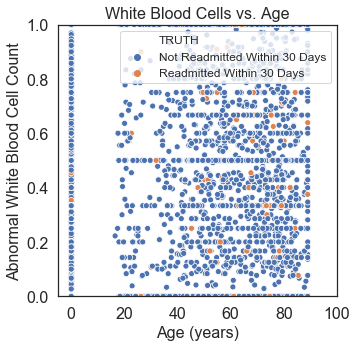

In [30]:
# Visualize all data for relevant patients

import pylab
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
sns.set()
sns.set_style("white")
cmap = sns.color_palette(n_colors=2)

sns.scatterplot(x="Age", y=design_mat_df["51301_ABNORMAL"],
                     hue="TRUTH",
                     palette=cmap, sizes=(10, 30),
                     data=pat_vis_data)

plt.axis((-5, 100, 0, 1))
plt.title('White Blood Cells vs. Age', fontsize=16)
plt.xlabel('Age (years)', fontsize=16)
plt.ylabel('Abnormal White Blood Cell Count', fontsize=16)
plt.legend(loc="upper right", fontsize=12)

x_ticks = np.array([0, 20, 40, 60, 80, 100])
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=0, fontsize=16)
y_ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(y_ticks, rotation=0, fontsize=16)

plt.savefig("Section3WbcAge.png", bbox_inches='tight')

### 3. t-SNE Visualization of Full Feature Matrix

Next, we visualize the final features using t-distributed stochastic neighborhood embedding (t-SNE), which is a non-linear dimensionality reduction technique that maps a high dimensional feature space to two dimensions for visualization. Clusters that are nearby in t-SNE space are also nearby in the higher dimensional space. The figure below is a t-SNE visualization of the 114 features in the design matrix, where the color represents the class. The figure indicates a substantial amount of overlap between the patients readmitted within 30 days and the other patients, which suggests that it may be challenging to create a classification model that can separate the two classes.

In [31]:
# Visualize in 2D using TSNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_train)

[Text(0,0,'-60'),
 Text(0,0,'-40'),
 Text(0,0,'-20'),
 Text(0,0,'0'),
 Text(0,0,'20'),
 Text(0,0,'40'),
 Text(0,0,'60')]

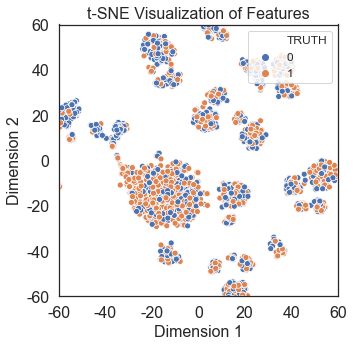

In [32]:
# Plot
plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
sns.set()
sns.set_style("white")
cmap = sns.color_palette(n_colors=2)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],
                     hue=y_train,
                     palette=cmap, sizes=(10, 30),
                     data=pat_vis_data)

plt.axis((-60, 60, -60, 60))
plt.title('t-SNE Visualization of Features', fontsize=16)
plt.xlabel('Dimension 1', fontsize=16)
plt.ylabel('Dimension 2', fontsize=16)
plt.legend(loc="upper right", fontsize=12)

x_ticks = np.array([-60, -40, -20, 0, 20, 40, 60])
ax.set_xticklabels(x_ticks, rotation=0, fontsize=16)
y_ticks = np.array([-60, -40, -20, 0, 20, 40, 60])
ax.set_yticklabels(y_ticks, rotation=0, fontsize=16)

## SECTION IV: MODELING

After creating our overall feature matrix and splitting the data into X_train, y_train, X_test, y_test we can begin to try out different models to see which work best with the data. This section first applies multiple classifiers to the data to identify which classifier performs best. In this particular section, all default parameters are left as is. Once the highest-performing classifier is identified in this section, we can begin to tune the parameters later on to optimize model performance.

### 1. Testing Different Classifiers With Default Parameters

First, five different classifiers (and their default parameters) were used to process the data. The five classifiers were Support Vector Machine (SVM), Logistic Regression (LR), AdaBoost, Bayes, and Random Forest. These are common classifiers that represent a wide range of diversity in classifier assumptions and strengths. Each classifier was fit to the training data and then evaluated using the testing data. Area Under the Curve (AUC) scores and Reciever Operating Characteristic (ROCs) curves were calculated for each classifier to identify model performance. 

In [33]:
# import sklearn metrics and all classifiers
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# this function takes a classifier, training and testing data to obtain a y_pred vector from which you can obtain an AUC metric as well as False Positive Rates (FPRs) and True Positive Rates (TPRs) to produce an ROC curve.
def evaluateClass(clf, X_train, y_train, X_test, y_test):
    clf = clf.fit(X_train, y_train)
    y_pred = clf.decision_function(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    return AUC, fpr, tpr

# Instantiate SVM classifier
svm = SVC(random_state=42)
# Calculate AUC, FPR, TPR for SVM classifier
svm_AUC, svm_fpr, svm_tpr = evaluateClass(svm, X_train, y_train, X_test, y_test)

# Instantiate LR classifier
LR = LogisticRegression(random_state=0)
# Calculate AUC, FPR, TPR for LR classifier
LR_AUC, LR_fpr, LR_tpr = evaluateClass(LR, X_train, y_train, X_test, y_test)

# Instantiate AdaBoost Classifier
Ada = AdaBoostClassifier()
# Calculate AUC, FPR, TPR for AdaBoost classifier
Ada_AUC, Ada_fpr, Ada_tpr = evaluateClass(Ada, X_train, y_train, X_test, y_test)

# The Bayes and Random Forest classifiers do not have the .decision_function() methods so they are computed separately below:
# Instantiate Bayes classifier
Bayes = GaussianNB()
# Train and test model
Bayes = Bayes.fit(X_train, y_train)
y_pred = Bayes.predict(X_test)
# Evaluating AUC, TPR, FPR
Bayes_fpr, Bayes_tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
Bayes_AUC = metrics.auc(Bayes_fpr, Bayes_tpr)

# Instantiate the RandomForest classifier
RandForest = RandomForestClassifier(random_state=0)
# Train and test model
RandForest = RandForest.fit(X_train, y_train)
y_pred = RandForest.predict(X_test)
# Evaluating AUC, TPR, FPR
RandForest_fpr, RandForest_tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
RandForest_AUC = metrics.auc(RandForest_fpr, RandForest_tpr)

# creating dataframe to display results
AUC_Class_df = pd.DataFrame({'Classifier':['SVM','LR','AdaBoost','Bayes','Random Forest'],'AUC':[svm_AUC, LR_AUC, Ada_AUC, Bayes_AUC, RandForest_AUC]})

/Users/kevinmchu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


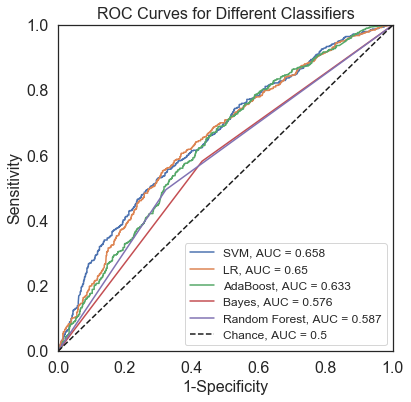

In [34]:
# Plot ROC curves for each classifier in one plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
plt.plot(svm_fpr, svm_tpr, label = "SVM, AUC = {}".format(round(svm_AUC, 3)))
plt.plot(LR_fpr, LR_tpr, label = "LR, AUC = {}".format(round(LR_AUC, 3)))
plt.plot(Ada_fpr, Ada_tpr, label = "AdaBoost, AUC = {}".format(round(Ada_AUC, 3)))
plt.plot(Bayes_fpr, Bayes_tpr, label = "Bayes, AUC = {}".format(round(Bayes_AUC, 3)))
plt.plot(RandForest_fpr, RandForest_tpr, label = "Random Forest, AUC = {}".format(round(RandForest_AUC, 3)))
plt.plot(np.array([0, 1]), np.array([0, 1]), 'k--', label = "Chance, AUC = {}".format(0.500))
plt.axis((0, 1, 0, 1))

# Cleaning up the ROC curve plot
plt.title("ROC Curves for Different Classifiers", fontsize=16)
plt.xlabel('1-Specificity', fontsize=16)
plt.ylabel('Sensitivity', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
x_ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(x_ticks, rotation=0, fontsize=16)
y_ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(y_ticks, rotation=0, fontsize=16)
#plt.savefig("ClassifiersDefaultParams.png", bbox_inches='tight')
plt.show()

In [35]:
AUC_Class_df

,Classifier,AUC
0,SVM,0.657719
1,LR,0.649706
2,AdaBoost,0.632605
3,Bayes,0.576176
4,Random Forest,0.586555


The higher the AUC value is, the better the performance of the algorithm is. Correspondingly, the closer the ROC curve gets to the point (0,1) on the plot, the better the performance is. Given this, from the ROC curves and the AUC values, we can see that SVM performs best. Therefore, in the following section we will focus in on SVM and optimize its parameters to improve overall model performance.

### 2. Hyperparameter Searching

This subsection focuses on optimizing the SVM classifier to improve algorithm performance. The code is commented out because this only needs to run once in order to identify the optimized parameters, which are then plugged into the SVM classifier that we instantiate ultimately for the classification and evaluation of this model. Because we have already run this and identified the optimized parameters, we have plugged them in and evaluated them in "Classification" and "Evaluation" subsections.

#### a. Set up cross-validation

For classification, we will use a support vector machine (SVM). An SVM classifier fits a decision boundary that simultaneously minimizes the error on the training set while maximizing the margin, or the distance between the decision boundary and the nearest point. The SVM uses a hyperparameter C that controls a trade-off between maximizing the margin and penalizing for incorrect classifications. In its original formulation, SVM can only create linear decision boundaries. To allow for non-linear decision boundaries, we use a radial basis function (RBF) kernel, governed by the parameter gamma, which can be interpreted as the width of the kernel. We optimize the hyperparameter C and the kernel width gamma through 10-fold cross-validation.

In [36]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

# Set up cross-validation folds
cv = StratifiedKFold(n_splits = 10)

# Number of features
nfeatures = np.shape(X_train)[1]

#### b. Set up parameter grid

Here, we perform a grid search over different combinations of the cost parameter C and the kernel width gamma. The possible values of C are 0.5, 1.0, 1.5, 2.0, 2.5, and 3.0, and the possible values of gamma are 0.5/D, 1.0/D, 1.5/D, and 2.0/D, where D is the number of features. We select the combination of C and gamma that maximize the area under the ROC curve (AUC) averaged across all 10 folds. As shown below, the best feature combination was determined to be C = 1.5 and gamma = 2/D.

In [37]:
# Parameter grid
params_grid = {
    'C': np.arange(0.5, 3.5, 0.5),
    'gamma': np.arange(0.5/nfeatures, 2.5/nfeatures, 0.5/nfeatures)
}

bst_grid = GridSearchCV(estimator = SVC(),
                       param_grid = params_grid,
                       cv = cv,
                       scoring = 'roc_auc')

bst_grid.fit(X_train, y_train)

bst_grid.best_params_

{'C': 2.0, 'gamma': 0.013157894736842105}

### 3. Classification

Now that we have identified the cost and gamma values that give us the best performing model, we can plug them directly into the SVM that is instantiated below, as seen. Next, we fit the SVM to the training data and then run the testing data.

In [38]:
# Instantiate the SVM classifier with the optimized parameters (cost = 1.5, gamma = 0.017857142857142856)
svm = SVC(C=1.5, gamma = 0.017857142857142856)
# Train and test the classifier
svm = svm.fit(X_train, y_train)
y_pred = svm.decision_function(X_test)

### 4. Evaluation

This subsection evaluates the performance of the optimized SVM classifier created above by calculating the false positive rates (FPRs), true positive rates (TPRs), and AUC score.

0.66226651706158


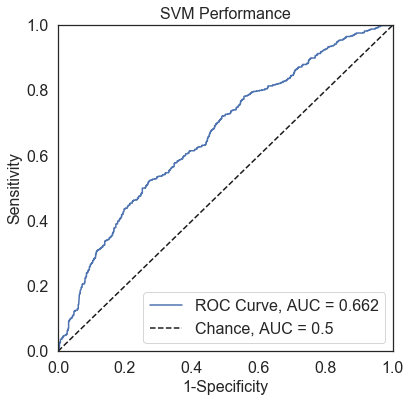

In [39]:
# Calculate FPR, TPR, and AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
AUC = metrics.auc(fpr, tpr)
print(AUC)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
plt.plot(fpr, tpr, label='ROC Curve, AUC = {}'.format(round(AUC,3)))
plt.plot(np.array([0, 1]), np.array([0, 1]), 'k--', label='Chance, AUC = {}'.format(round(0.5,2)))
plt.axis((0, 1, 0, 1))

# Labels
plt.title('SVM Performance', fontsize=16)
plt.xlabel('1-Specificity', fontsize=16)
plt.ylabel('Sensitivity', fontsize=16)
plt.legend(fontsize=16)
x_ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(x_ticks, rotation=0, fontsize=16)
y_ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(y_ticks, rotation=0, fontsize=16)
#plt.savefig("SvmWithCvParams.png", bbox_inches='tight')
plt.show()

Therefore, the final model produces an AUC score of 0.66 and the ROC curve as seen in the figure above. It is worth noting that this AUC score of the optimized SVM is higher (as expected) than the AUC score of the original, default SVM classifier which was 0.659. While the increase in performance is marginal, every bit counts when striving for better performance.

## SECTION V: SUGGESTIONS